## Procesamiento de datos

Se cargan las librerías.

In [76]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Se cargan los datos.

In [59]:
segmentos = []

# Leer los archivos CSV segmentados y almacenarlos en la lista
for i in range(0,4):
    segmento = pd.read_csv(f'../data/raw/segmento_{i+1}.csv')
    segmentos.append(segmento)
# Concatenar los DataFrames de los segmentos en uno solo
df1 = pd.concat(segmentos, ignore_index=True)

Se obtienen nuvas features a partir del Dataframe.

Se obtiene la edad del cliente en la fecha en la que ha realizado la transacción bancaria

In [60]:
df1["dob"] = pd.to_datetime(df1["dob"])  # Convertir la columna "dob" a tipo de dato datetime
df1["trans_date_trans_time"] = pd.to_datetime(df1["trans_date_trans_time"])  # Convertir la columna "trans_date_trans_time" a tipo de dato datetime


df1["age"] = df1.apply(lambda row: relativedelta(row["trans_date_trans_time"], row["dob"]).years, axis=1)

Se obtiene la distancia entre el domicilio del cliente y el establecimiento donde se ha realizado la compra.

In [61]:
# Función para calcular la distancia entre dos puntos
def calcular_distancia(row):
    comercio_coords = (row['lat'], row['long'])
    cliente_coords = (row['merch_lat'], row['merch_long'])
    distancia = geodesic(comercio_coords, cliente_coords).km
    return distancia

# Aplicar la función a cada fila del DataFrame
df1['distancia'] = df1.apply(calcular_distancia, axis=1)

Se obtiene la hora y el día de la semana de la transacción.

In [62]:
# Convertir la columna "trans_date_trans_time" a tipo de dato datetime
df1["trans_date_trans_time"] = pd.to_datetime(df1["trans_date_trans_time"])

# Generar columna con la hora (del 0 al 23) de la transacción
df1["hour"] = df1["trans_date_trans_time"].dt.hour

# Generar columna con el día de la semana (del 1 al 7) de la transacción
df1["day_of_week"] = df1["trans_date_trans_time"].dt.dayofweek + 1

# Generar columna con el día del mes (del 1 al 31) de la transacción
df1["day_of_month"] = df1["trans_date_trans_time"].dt.day

Se obtiene una nueva variable dividiendo el total de fraudes cometidos en cada categoría de establecimiento entre el totale de fraudes para así asignar un valor numérico proporcional a cada categoría.

In [63]:
total_fraudes = df1[df1["is_fraud"] == 1]["is_fraud"].sum()
fraudes_por_categoria = df1[df1["is_fraud"] == 1].groupby("category")["is_fraud"].sum()

# Calcular los pesos de cada hora en función de la suma de fraudes
valor_categoria = fraudes_por_categoria / total_fraudes

# Crear una nueva columna llamada "peso_hora" utilizando la función map()
df1["fraudes_por_Categoria"] = df1["category"].map(valor_categoria)

Se obtiene una nueva variable dividiendo el total de fraudes cometidos en cada estado entre el totale de fraudes para así asignar un valor numérico proporcional a cada estado.

In [64]:
fraudes_por_estado = df1[df1["is_fraud"] == 1].groupby("state")["is_fraud"].sum()

# Calcular los pesos de cada hora en función de la suma de fraudes
valor_estado = fraudes_por_estado / total_fraudes

# Crear una nueva columna llamada "peso_hora" utilizando la función map()
df1["fraudes_por_estado"] = df1["state"].map(valor_estado)

Se crea un Dataframe balanceado para visualizar mejor la relación entre la hora y el día de la semana y los fraudes que se cometen.

In [65]:
counts = df1['is_fraud'].value_counts()

# Encuentra la clase con el menor número de instancias
minority_class = counts.idxmin()

# Filtra el DataFrame para obtener solo instancias de la clase minoritaria
minority_df = df1[df1['is_fraud'] == minority_class]

# Obtiene una muestra aleatoria de la clase mayoritaria del mismo tamaño que la clase minoritaria
majority_df = df1[df1['is_fraud'] != minority_class].sample(n=len(minority_df), random_state=42)

# Combina los DataFrames de la clase minoritaria y la muestra de la clase mayoritaria
undersampled_df = pd.concat([minority_df, majority_df])

# Mezcla aleatoriamente las instancias en el DataFrame resultante
df_balanced= undersampled_df.sample(frac=1, random_state=42)

Visualización del recuento de fraudes por edad en un Dataframe balanceado.

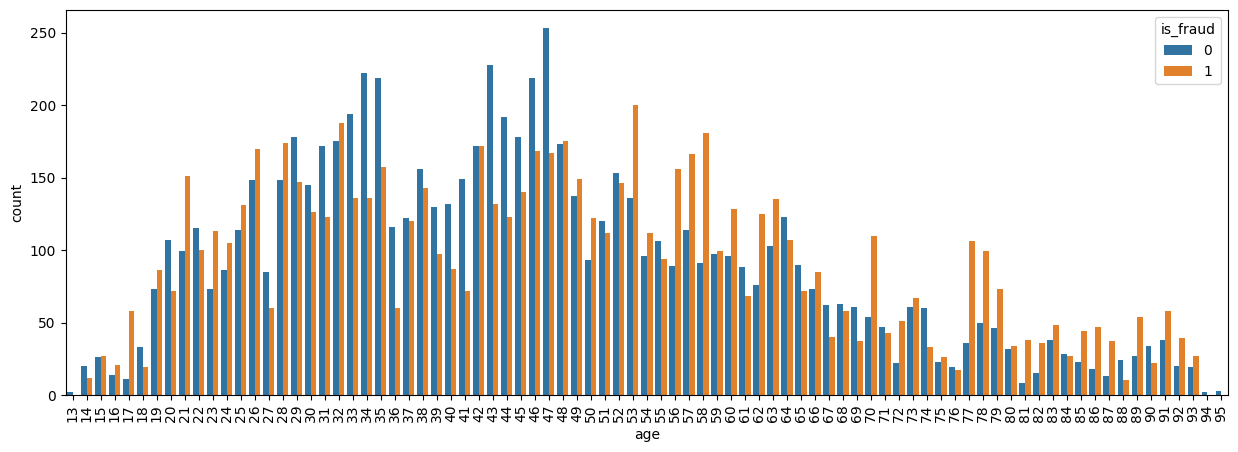

In [66]:
plt.figure(figsize=(15,5))
sns.countplot(x="age", hue="is_fraud", data=df_balanced)
plt.xticks(rotation=90);

Se puede observar que a ciertas edades hay más casos de fraude. Se obtiene una nueva variable dividiendo el total de fraudes cometidos a cada edad entre el totale de fraudes para así asignar un valor numérico proporcional a cada edad.

In [67]:
fraudes_por_edad = df1[df1["is_fraud"] == 1].groupby("age")["is_fraud"].sum()

# Calcular los pesos de cada hora en función de la suma de fraudes
valor_edad = fraudes_por_edad / total_fraudes

# Crear una nueva columna llamada "peso_hora" utilizando la función map()
df1["fraudes_por_edad"] = df1["age"].map(valor_edad)

Visualización del recuento de fraudes a cada hora del día en un Dataframe balanceado.

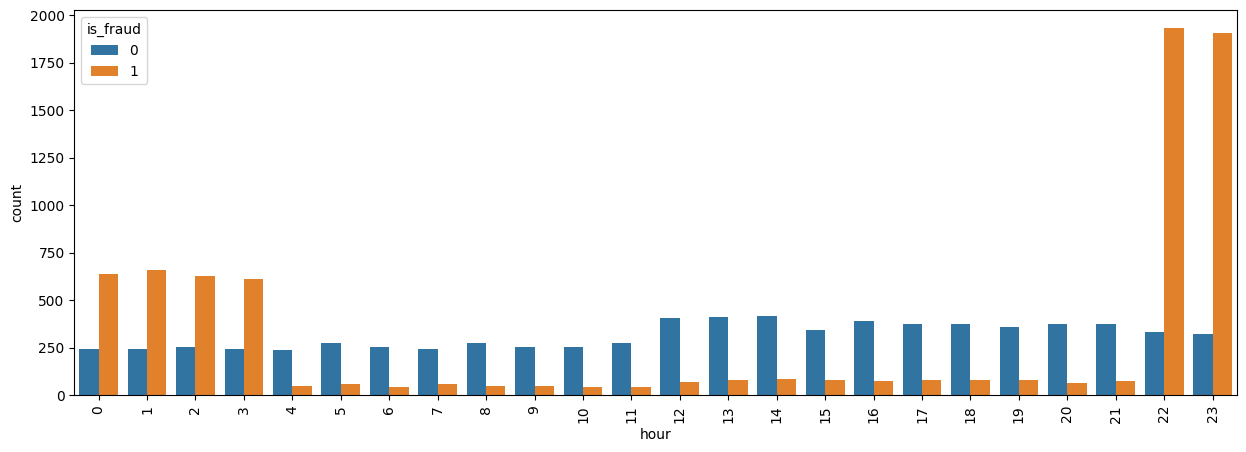

In [68]:
plt.figure(figsize=(15,5))
sns.countplot(x="hour", hue="is_fraud", data=df_balanced)
plt.xticks(rotation=90);

Se puede observar que a ciertas horas se cometen muchos más fraudes que a otras. Se obtiene una nueva variable dividiendo el total de fraudes cometidos en cada estado entre el totale de fraudes para así asignar un valor numérico proporcional a cada estado.

In [69]:
fraudes_por_hora = df1[df1["is_fraud"] == 1].groupby("hour")["is_fraud"].sum()

# Calcular los pesos de cada hora en función de la suma de fraudes
valor_hora = fraudes_por_hora / total_fraudes

# Crear una nueva columna llamada "peso_hora" utilizando la función map()
df1["fraudes_por_hora"] = df1["hour"].map(valor_hora)

Visualización del recuento de fraudes a cada hora del día en un Dataframe balanceado.

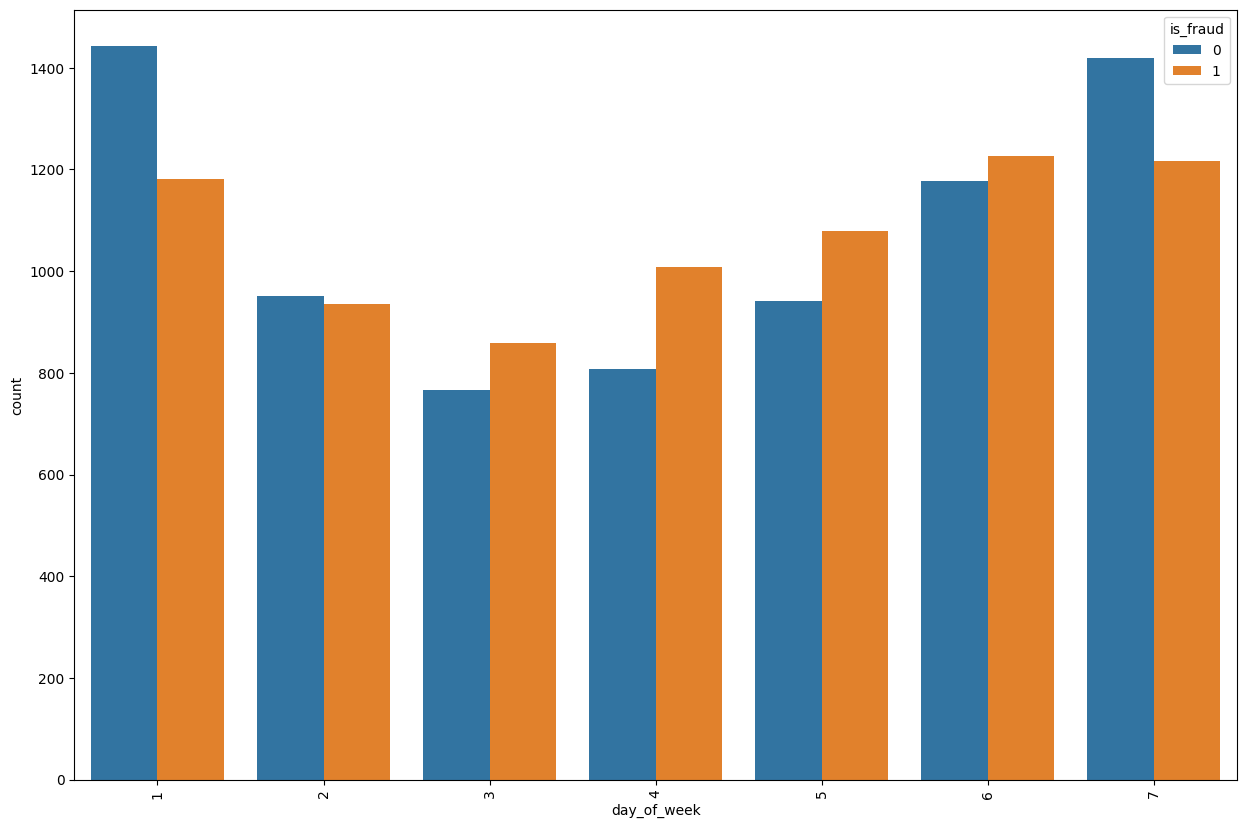

In [70]:
plt.figure(figsize=(15,10))
sns.countplot(x="day_of_week", hue="is_fraud", data=df_balanced)
plt.xticks(rotation=90);

Al ver que la relación entre fraude y no fraude es bastante similar, no utilizaremos esta variable.

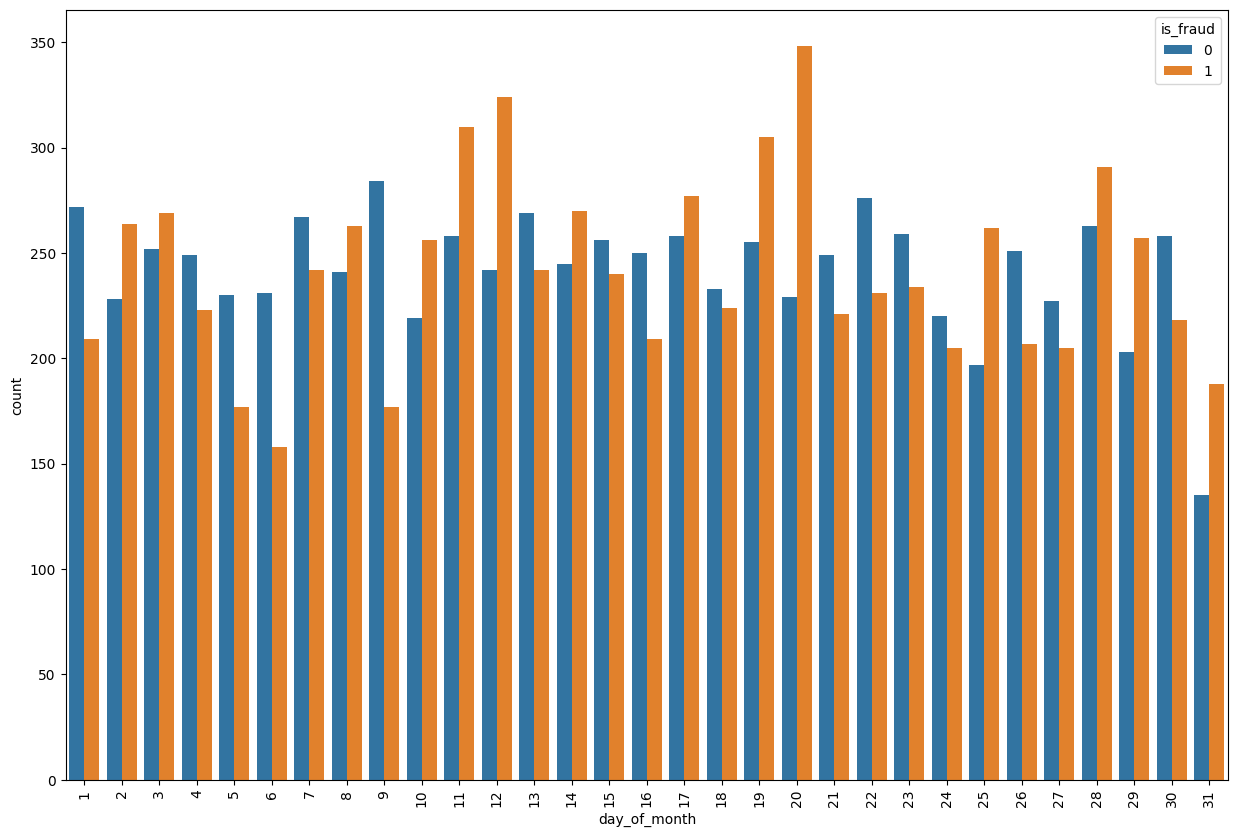

In [71]:
plt.figure(figsize=(15,10))
sns.countplot(x="day_of_month", hue="is_fraud", data=df_balanced)
plt.xticks(rotation=90);

Se puede observar que hay un repunte de fraudes ciertos días del mes. Se obtiene una nueva variable dividiendo el total de fraudes cometidos cada día entre el totale de fraudes para así asignar un valor numérico proporcional a cada día.

In [72]:
fraudes_por_dia = df1[df1["is_fraud"] == 1].groupby("day_of_month")["is_fraud"].sum()

# Calcular los pesos de cada hora en función de la suma de fraudes
valor_dia = fraudes_por_dia / total_fraudes

# Crear una nueva columna llamada "peso_hora" utilizando la función map()
df1["fraudes_por_día"] = df1["day_of_month"].map(valor_dia)

Se eliminan las columnas que finalmente no se tendrán en cuenta a la hora de realizar el modelo.

In [73]:
df1.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'age', 'distancia', 'hour', 'day_of_week',
       'day_of_month', 'fraudes_por_Categoria', 'fraudes_por_estado',
       'fraudes_por_edad', 'fraudes_por_hora', 'fraudes_por_día'],
      dtype='object')

In [74]:
df1.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'age', 'hour', 'day_of_week', 'day_of_month'], inplace=True, axis=1)

Nuevo Dataframe.

In [75]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   amt                    1296675 non-null  float64
 1   city_pop               1296675 non-null  int64  
 2   is_fraud               1296675 non-null  int64  
 3   distancia              1296675 non-null  float64
 4   fraudes_por_Categoria  1296675 non-null  float64
 5   fraudes_por_estado     1296675 non-null  float64
 6   fraudes_por_edad       1296059 non-null  float64
 7   fraudes_por_hora       1296675 non-null  float64
 8   fraudes_por_día        1296675 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 89.0 MB


Pasamos el nuevo Dataframe a un csv.

In [ ]:
segmentos = []

segmentos = np.array_split(df1, 3)

for i, segmento in enumerate(segmentos):
    segmento.to_csv(f'../data/processed/segmento_{i+1}.csv', index=False)
